In [1]:
# imports for files
import glob # for getting filenames matching an expression
from os import path
from os import mkdir
from os import makedirs
# imports for images and plots
import PIL
from matplotlib import pyplot as plt
# imports for deep learning
import tensorflow as tf
from tensorflow import keras
# misc
import random
from math import prod

2023-06-27 07:10:48.240038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 07:10:49.334418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
COLAB = None
try:
    # only for google drive linking (on Colab)
    from google.colab import drive
    # Link Google Drive account to use relative pathnames
    drive.mount('/content/gdrive')
    COLAB = True
except:
    COLAB = False
print("Notbook is running in Colab environment:", COLAB)

Notbook is running in Colab environment: False


# See in the dark

## Dataset

### Input directory

Define the path to the directory containing the `Sony` folder, it will be also used as base path for saving checkpoints, models and other outputs

In [3]:
# -- Set your base directory --
#base_dir = './'

# Edo [desktop]
base_dir = "/mnt/e/Data/Deep Learning/See in the dark"

# Davide, Alberto [Colab]
#base_dir = './gdrive/MyDrive/Progetto Deep Learning/Learning-to-See-in-the-Dark/dataset/'

# Edo [Colab]
#base_dir = './gdrive/MyDrive/Data Science/Progetto Deep Learning/Learning-to-See-in-the-Dark/dataset/'

Verify the provided base path: we check the `Sony` folder is present. `Fuji` is the other dataset but we work only on Sony.

In [4]:
base_dir = path.normpath(base_dir)
print("Found Sony folder:", path.isdir(path.join(base_dir, './Sony/')))
print("Found Fuji folder:", path.isdir(path.join(base_dir, './Fuji/')))

Found Sony folder: True
Found Fuji folder: False


### Input file paths

Images file names are built like

```
AB_C_Ds.extension
```

- `A` (1 digit) is the number that discriminates the training, testing and validation sets
  - Training: starts with 0
  - Testing: starts with 1
  - Validation: starts with 2
- `B` (4 digits) is the identifier of the subject of the photo, photos with same B represents the same subject
- `C` (2 digits) is the shot number, but sometimes there is more than one shot with different exposure time and same shot number
- `D` is the exposure time in seconds

Images are divided at the root in two folders

- `short` for short exposure images, that are the network input
- `long` for long exposure images, that are the output ground truth

Ground truth images always have `C` = 00 and `D` = 10 or 30, there is only one shot per subject.

Input images typically has `C` between 00 and 09 and `D` = 0.1 but also 0.033 and 0.04 sometimes, images of the same subject are very very similar since all camera parameters are the same.

In [5]:
dark_dir = path.normpath(path.join(base_dir, './Sony/short/png 8bit/'))
clear_dir = path.normpath(path.join(base_dir, './Sony/long/png 8bit/'))
print("dark_dir is valid:", path.isdir(dark_dir))
print("clear_dir is valid:", path.isdir(clear_dir))

dark_dir is valid: True
clear_dir is valid: True


In [6]:
input_extension = "png"

training_in = glob.glob(path.join(dark_dir, '0*' + '.'+input_extension))
print("Input training images found:", len(training_in))

testing_in = glob.glob(path.join(dark_dir, '1*' + '.'+input_extension))
print("Input testing images found:", len(testing_in))

validation_in = glob.glob(path.join(dark_dir, '2*' + '.'+input_extension))
print("Input validation images found:", len(validation_in))

Input training images found: 1865
Input testing images found: 598
Input validation images found: 234


We want the list of ground truth images to be of the same length of the input lists, in order to have a one-to-one correspondence with input and ground truth.

Given the image naming and that multiple input images can have a common ground truth image, we match couples by the image group identifier `A` and subject identifier `B`.

In [7]:
def get_img_path_list_out(img_path_list_in: list[str]) -> list[str]:
    img_path_list_out = []
    for img_path in img_path_list_in:
        name = path.basename(img_path)
        extension = path.splitext(name)[1]
        out = glob.glob(path.join(clear_dir, name[0:5] + '*' + extension))[0]
        out = path.normpath(out)
        img_path_list_out.append(out)
    return img_path_list_out

training_out = get_img_path_list_out(training_in)
print("Ground truth training images have same length of input:", len(training_in)==len(training_out))

testing_out = get_img_path_list_out(testing_in)
print("Ground truth testing images have same length of input:", len(testing_in)==len(testing_out))

validation_out = get_img_path_list_out(validation_in)
print("Ground truth validation images have same length of input:", len(validation_in)==len(validation_out))

Ground truth training images have same length of input: True
Ground truth testing images have same length of input: True
Ground truth validation images have same length of input: True


In [8]:
def print_matches(img_path_list_in: list[str], img_path_list_out: list[str]) -> None:
    n = max(len(img_path_list_in), len(img_path_list_out))
    for i in range(n):
        
        if (i >= len(img_path_list_in)):
            name_in = "NOT FOUND"
        else:
            name_in = path.basename(img_path_list_in[i])
        
        if (i >= len(img_path_list_out)):
            name_out = "NOT FOUND"
        else:
            name_out = path.basename(img_path_list_out[i])
        
        print(f"{name_in} -> {name_out}")

#print_matches(training_in, training_out)
#print_matches(testing_in, testing_out)
#print_matches(validation_in, validation_out)

### Input images

All images have original height 2840 and width 4246.

`img_height` and `img_width` are the parameters for the network input size. We half the image size both for performance and for supporting input from not-so-good cameras.

In [9]:
img_height = int(2840/10)
img_width = int(4246/10)
img_channels = 3

Function to read images from disk that also resize them to the target dimension, the output is a Pillow image

In [10]:
def read_image(image_path: str) -> PIL.Image.Image:
    return keras.utils.load_img(
        image_path,
        target_size = (img_height, img_width),
        interpolation = "bilinear",
    )

Functions to check tensor data, to asses that the tensor can directly represent an image of `img_channels` channels where each value goes from 0 to 255 (data type `uint8`).

We call tensors that respect this properties image tensors (`image_tensor` is the first part of the name of the functions)

In [11]:
def image_tensor_shape_check(image_tensor: tf.Tensor) -> None:
    # if image_tensor is not of the provided shape, an exception is raised
    tf.ensure_shape(image_tensor, [None, None, img_channels])

def image_tensor_type_check(image_tensor: tf.Tensor) -> None:
    # if image_tensor is not a tensor of type uint8, an exception is raised
    if image_tensor.dtype != tf.uint8:
        raise TypeError("image tensor is not of type `tf.uint8`")

def image_tensor_check(image_tensor: tf.Tensor) -> None:
    image_tensor_shape_check(image_tensor)
    image_tensor_type_check(image_tensor)

Function to convert Pillow image to an image tensor

In [12]:
def image_to_tensor(image: PIL.Image.Image) -> tf.Tensor:
    image_tensor = tf.convert_to_tensor(image)
    image_tensor_check(image_tensor)
    return image_tensor

Functions to convert a tensor that is not an image tensor into an image tensor. All numerical data types are accepted.

- Proportion: makes a proportion with the maximum value of the input data type to get values from 0 to 255. We expect input values to span from negative numbers to `3.409e+38` for a standard `float32` data type, in this scenario a value of 1 in `uint8` is more than `1e+36`, the values will vary a lot.
- Capping: makes 255 all values greater then 255. We expect input values near to the actual `uint8` range, that is from 0 to 255, the values will be rounded during data type conversion

In both cases, values below 0 are set to 0.

In [13]:
def tensor_to_image_tensor_proportion(tensor: tf.Tensor) -> tf.Tensor:
    image_tensor_shape_check(tensor)
    # make all negative numbers positive
    tensor_without_infinity = tf.math.minimum(tensor, tensor.dtype.max)
    tensor_non_negative = tf.math.maximum(tensor_without_infinity, 0)
    # proportion
    maxvalue = tensor.dtype.max
    tensor_proportion_255 = tf.math.multiply(tf.math.divide(tensor_non_negative, maxvalue), 255)
    return tf.cast(tensor_proportion_255, tf.uint8)

def tensor_to_image_tensor_cap(tensor: tf.Tensor) -> tf.Tensor:
    image_tensor_shape_check(tensor)
    # make all negative numbers positive
    tensor_without_infinity = tf.math.minimum(tensor, tensor.dtype.max)
    tensor_non_negative = tf.math.maximum(tensor_without_infinity, 0)
    # capping
    tensor_cap_255 = tf.math.minimum(tensor_non_negative, 255)
    return tf.cast(tensor_cap_255, tf.uint8)

In [14]:
# test
t1 = tf.constant([
    [
        [265, 265, 265],
        [255, 255, 255],
        [255, 255, 255],
    ],
    [
        [0  , 1  , 2  ],
        [100, 101, 102],
        [200, 201, 202],
    ],
    [
        [0  , 0  , 0  ],
        [0  , 0  , 0  ],
        [0  , 0  , 0  ],
    ]
], dtype = tf.uint8)
print(" -- test uint8 --")
print("max value:", tf.uint8.max)
image_tensor_shape_check(t1)
image_tensor_type_check(t1)
print(t1)
print(tensor_to_image_tensor_proportion(t1))
print(tensor_to_image_tensor_cap(t1))

t2 = tf.constant([
    [
        [9147483647, 9147483647, 9147483647],
        [2147483647, 2147483647, 2147483647],
        [2147483647, 2147483647, 2147483647],
    ],
    [
        [0         , 10000000  , 100000000 ],
        [1000000000, 1010000000, 1100000000],
        [2000000000, 2000000000, 2100000000],
    ],
    [
        [0         , 0         , 0         ],
        [0         , 0         , 0         ],
        [0         , 0         , 0         ],
    ]
], dtype = tf.int32)
print(" -- test int32 --")
print("max value:", tf.int32.max)
image_tensor_shape_check(t2)
#image_tensor_type_check(t2)
print(t2)
print(tensor_to_image_tensor_proportion(t2))
print(tensor_to_image_tensor_cap(t2))

t3 = tf.constant([
    [
        [3.4028235e+39, 3.4028235e+39, 3.4028235e+39],
        [3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
        [3.4028235e+38, 3.4028235e+38, 3.4028235e+38],
    ],
    [
        [1e+36        , 1e+37        , 1e+38        ],
        [2e+36        , 2e+37        , 2e+38        ],
        [3e+36        , 3e+37        , 3e+38        ],
    ],
    [
        [-1           , -1           , -1           ],
        [0            , 0            , 0            ],
        [-3.402823e+39, -3.402823e+38, -3.402823e+37],
    ]
], dtype = tf.float32)
print(" -- test float32 --")
print("max value:", tf.float32.max)
image_tensor_shape_check(t3)
#image_tensor_type_check(t3)
print(t3)
print(tensor_to_image_tensor_proportion(t3))
print(tensor_to_image_tensor_cap(t3))

2023-06-27 07:11:14.575436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


 -- test uint8 --
max value: 255
tf.Tensor(
[[[  9   9   9]
  [255 255 255]
  [255 255 255]]

 [[  0   1   2]
  [100 101 102]
  [200 201 202]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]]], shape=(3, 3, 3), dtype=uint8)
tf.Tensor(
[[[  9   9   9]
  [255 255 255]
  [255 255 255]]

 [[  0   1   2]
  [100 101 102]
  [200 201 202]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]]], shape=(3, 3, 3), dtype=uint8)
tf.Tensor(
[[[  9   9   9]
  [255 255 255]
  [255 255 255]]

 [[  0   1   2]
  [100 101 102]
  [200 201 202]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]]], shape=(3, 3, 3), dtype=uint8)
 -- test int32 --
max value: 2147483647
tf.Tensor(
[[[ 557549055  557549055  557549055]
  [2147483647 2147483647 2147483647]
  [2147483647 2147483647 2147483647]]

 [[         0   10000000  100000000]
  [1000000000 1010000000 1100000000]
  [2000000000 2000000000 2100000000]]

 [[         0          0          0]
  [         0          0          0]
  [         0          0          0]]], 

2023-06-27 07:11:14.814141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 07:11:14.814206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 07:11:14.817692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 07:11:14.817750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 07:11:14.817797: I tensorflow/compile

Functions to convert tensors to Pillow image. The first only accepts image tensors, the other includes a conversion from tensor to an image tensor.

In [15]:
def image_tensor_to_image(image_tensor: tf.Tensor) -> PIL.Image.Image:
    image_tensor_check(image_tensor)
    image_array = image_tensor.numpy()
    # image_array is now a numpy array of type uint8
    return keras.utils.array_to_img(image_array)

def tensor_to_image(tensor: tf.Tensor) -> PIL.Image.Image:
    return image_tensor_to_image(tensor_to_image_tensor_cap(tensor))

Function to write image to disk, png format

In [16]:
def write_image(image: PIL.Image.Image, image_path: str) -> None:
    image.save(image_path)

def save_image(image: PIL.Image.Image, name: str = "image_out", folder: str = "", extension: str = "png") -> str:
    image_folder_path = path.normpath(path.join(base_dir, "./output/"+folder))
    if not path.exists(image_folder_path):
        makedirs(image_folder_path)
    image_path = path.join(image_folder_path, name+"."+extension)
    write_image(image, image_path)
    return image_path

Image test

Path: /mnt/e/Data/Deep Learning/See in the dark/Sony/long/png 8bit/00038_00_10s.png
training_out index: 284


-- Pillow image --  <class 'PIL.Image.Image'>
Image format: None
Image mode: RGB
Image size: (424, 284)
Height:  284
Width:  424
Channels:  3 ('R', 'G', 'B')
-- Tensor image --  <class 'tensorflow.python.framework.ops.EagerTensor'>
Tensorflow tensor imge: <dtype: 'uint8'> (284, 424, 3)
Tensor size: 361.248 KBytes
Tensor values preview (blue channel of upper left corner):
 [[51 53 53 53 54 54 54 54 55 54]
 [52 54 54 55 55 55 55 53 54 53]
 [55 55 54 55 54 53 55 55 55 55]
 [54 54 55 54 55 53 55 56 55 54]
 [55 55 54 55 55 55 55 56 54 55]
 [54 53 54 55 55 55 55 55 55 55]
 [57 55 54 54 54 54 54 55 54 54]
 [57 58 57 56 55 56 56 56 56 57]
 [57 57 57 56 56 58 61 56 56 57]
 [56 57 57 57 56 56 58 57 57 56]]
- image -


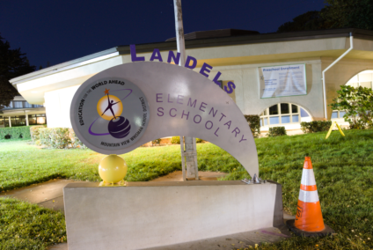

- corresponding dark image -


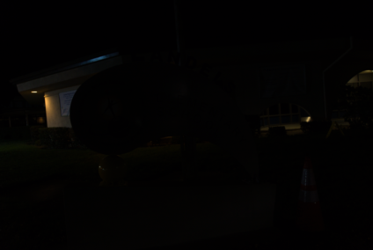

- image re-generated from tensor image -


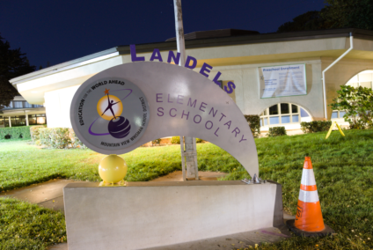

- image saved -
/mnt/e/Data/Deep Learning/See in the dark/output/image_out.png


In [17]:
index = random.randrange(len(training_out))

img_path = training_out[index]
print("Path:", img_path)
print("training_out index:", index)

img = read_image(img_path)
print("-- Pillow image -- ", type(img))
print("Image format:", img.format)
print("Image mode:", img.mode)
print("Image size:", img.size)
print("Height: ", img.height)
print("Width: ", img.width)
print("Channels: ", len(img.split()), img.getbands())

img_tensor = image_to_tensor(img)
print("-- Tensor image -- ", type(img_tensor))
print("Tensorflow tensor imge:", img_tensor.dtype, img_tensor.shape)
print("Tensor size:",
    # dtype uint8 size * tensor dimensions
    # uint8 size = 8 bits = 1 Byte
    1 * prod(img_tensor.shape) / 1000,
    "KBytes"
)
print("Tensor values preview (blue channel of upper left corner):\n", img_tensor.numpy()[0:10,0:10,2])

def resize_image(image: PIL.Image.Image, height=250):
    return(image.resize((int(height/image.height*image.width), height)))

print("- image -")
#img.show() # for Python standard code
display(resize_image(img)) # for Python notebook

print("- corresponding dark image -")
img_dark = read_image(training_in[index])
display(resize_image(img_dark))

print("- image re-generated from tensor image -")
display(resize_image(image_tensor_to_image(img_tensor)))

print("- image saved -")
print(save_image(img))

### Data augmentation

TensorFlow gives us many option for data augmentation, but we must avoid every kind of color values preprocessing due to the nature of the objective.

We make data augmentation rotating and flipping the image. Since we do not have square images, we only can rotate 180 degrees per time. Since a rotaion of 180 degrees can be obtained through an horizontal and a vertical flip together, we make the data augmentation function without using rotation functions but at the same time obtaining rotation.

With probabilities of flipping both 0.5 we have

- Probability of image not augmented: 1/25
- Probability of image upside down: 1/25
- Probability of image mirrored: 1/25
- Probability of image rotated 180 deg: 1/25

In [18]:
def data_augmentation(image_input: tf.Tensor, image_ground_truth: tf.Tensor, probability_flip_vertical = 0.5, probability_flip_horizontal = 0.5) -> tuple[tf.Tensor, tf.Tensor]:
    image_input_augmented = image_input
    image_ground_truth_augmented = image_ground_truth
    if random.random() < probability_flip_horizontal:
        image_input_augmented = tf.image.flip_up_down(image_input_augmented)
        image_ground_truth_augmented = tf.image.flip_up_down(image_ground_truth_augmented)
    if random.random() < probability_flip_vertical:
        image_input_augmented = tf.image.flip_left_right(image_input_augmented)
        image_ground_truth_augmented = tf.image.flip_left_right(image_ground_truth_augmented)
    return image_input_augmented, image_ground_truth_augmented

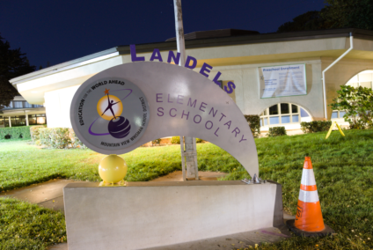

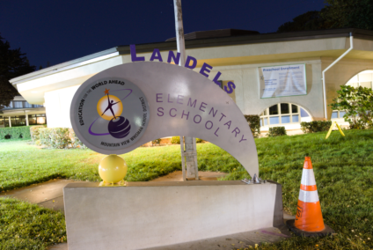

In [19]:
img_tensor_augmented1, img_tensor_augmented2 = data_augmentation(img_tensor, img_tensor)
display(resize_image(image_tensor_to_image(img_tensor_augmented1)))
display(resize_image(image_tensor_to_image(img_tensor_augmented2)))

### Tensorflow dataset

Define the type of the tensor to which the image will be converted to

In [20]:
image_data_shape = (img_height, img_width, img_channels)
image_tensor_spec = tf.TensorSpec(
    shape = image_data_shape,
    dtype = tf.uint8
)
image_data_shape

(284, 424, 3)

The datasets created as follows will be an iterable of tuples `(tensor_image_in, tensor_image_out)`, where the images are loaded in memory only when necessary.

In [21]:
# this function creates a dataset generator function
def get_dataset_generator(img_path_list_in: list[str], img_path_list_out: list[str], augmentation = True):
    
    # the dataset generator function must yield the elements to be fed to the network later
    def dataset_generator_without_augmentation():
        # iterate until one of the two lists does not end, although in theory the lengths are equal
        for i in range(min(len(img_path_list_in), len(img_path_list_out))):
            # yield couples of input image and ground truth image
            # the image is a PIL image, that must be converted to tensor in order to be fed to the network
            yield tf.convert_to_tensor(read_image(img_path_list_in[i])), tf.convert_to_tensor(read_image(img_path_list_out[i]))
    
    # with augmentation
    def dataset_generator_with_augmentation():
        for i in range(min(len(img_path_list_in), len(img_path_list_out))):
            yield data_augmentation(tf.convert_to_tensor(read_image(img_path_list_in[i])), tf.convert_to_tensor(read_image(img_path_list_out[i])))

    # put the "if augmentation" outside the generator function for a small performance improvement
    if (augmentation):
        return dataset_generator_with_augmentation
    else:
        return dataset_generator_without_augmentation

In [22]:
dataset_training = tf.data.Dataset.from_generator(
    get_dataset_generator(training_in, training_out, augmentation = False),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
# set cardinality
dataset_training = dataset_training.apply(tf.data.experimental.assert_cardinality(len(training_in)))

dataset_testing = tf.data.Dataset.from_generator(
    get_dataset_generator(testing_in, testing_out, augmentation = False),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_testing = dataset_testing.apply(tf.data.experimental.assert_cardinality(len(testing_in)))

dataset_validation = tf.data.Dataset.from_generator(
    get_dataset_generator(validation_in, validation_out, augmentation = False),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_validation = dataset_validation.apply(tf.data.experimental.assert_cardinality(len(validation_in)))

In [23]:
dataset_training_augmented = tf.data.Dataset.from_generator(
    get_dataset_generator(training_in, training_out, augmentation = True),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_training_augmented = dataset_training.apply(tf.data.experimental.assert_cardinality(len(training_in)))

dataset_testing_augmented = tf.data.Dataset.from_generator(
    get_dataset_generator(testing_in, testing_out, augmentation = True),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_testing_augmented = dataset_testing.apply(tf.data.experimental.assert_cardinality(len(testing_in)))

dataset_validation_augmented = tf.data.Dataset.from_generator(
    get_dataset_generator(validation_in, validation_out, augmentation = True),
    output_signature = (image_tensor_spec, image_tensor_spec)
)
dataset_validation_augmented = dataset_validation.apply(tf.data.experimental.assert_cardinality(len(validation_in)))

## Model training setup

### Losses to test

SSIM is used to measure the similarity between two images. It is a perception-based model that considers image degradation as perceived change in structural information. The SSIM score is equal to 1 when the two images are identical.

`tf.image.ssim_multiscale` is the implementation of the SSIM score and not the loss. When used as loss, it often returns `NaN`s (see [GitHub issue 57353](https://github.com/tensorflow/tensorflow/issues/57353)) this could also be a correct mathematical result since the SSIM can return complex results: "Even if the range of SSIM is allowed to be complex, there are no descriptions on how to interpret such values. To our knowledge, this problem has never been identified before and means that SSIM implementations can generate undefined results for some inputs and parameters settings" ([arxiv.org/abs/2006.13846](https://arxiv.org/abs/2006.13846))

In [24]:
def ssim_loss(y_true, y_pred):
    tf_true = tf.cast(y_true, tf.float32)
    tf_pred = tf.cast(y_pred, tf.float32)
    ssim_score = tf.reduce_mean(tf.image.ssim_multiscale(tf_true, tf_pred, max_val = 255)) # difference between ground truth and the prediction
    return 1 - ssim_score # 1 - ssim score

In [25]:
loss_mae = keras.losses.MeanAbsoluteError()
loss_mse = keras.losses.MeanSquaredError()
loss_ssim = ssim_loss
losses = [loss_mae, loss_mse, loss_ssim]

### Activations to test

Activation functions that we take into account.

Leaky ReLU slope `0.2` is taken from the paper "Low-Light Image and Video Enhancement Using Deep Learning: A Survey" Chongyi Li, Chunle Guo, Linghao Han, Jun Jiang, Ming-Ming Cheng (Senior Member IEEE), Jinwei Gu (Senior Member IEEE) and Chen Change Loy (Senior Member IEEE), Nov 2021 ([arxiv.org/abs/2104.10729](https://arxiv.org/abs/2104.10729)).

In [26]:
activation_layer_relu = keras.layers.ReLU
activation_layer_lrelu = lambda: keras.layers.LeakyReLU(alpha = 0.2)
activations = [activation_layer_relu, activation_layer_lrelu]

### Metrics

In [27]:
metrics = losses + ["accuracy"]

In [28]:
metrics_history_names = [
    # first list value is the name to print
    ["Mean Absolute Error", "mean_absolute_error", "val_mean_absolute_error"],
    ["Mean Squared Error", "mean_squared_error", "val_mean_squared_error"],
    #["SSIM", "ssim_loss", "val_ssim_loss"],
    #["Loss", "loss", "val_loss"],
    #["Accuracy", "accuracy", "val_accuracy"],
]

def plot_metrics(history, chosen_loss_str, xlim = None):
    rows = 1
    cols = 2
    _, axs = plt.subplots(
        rows,
        cols,
        layout = "constrained", # do not overlap axes
        figsize = (14,14/4), # size of each plot in inches
    )

    # keep track of metrics_history_names index
    i = 0
    # for each row and column
    #for row in range(rows):
    for col in range(cols):
        #ax = axs[row][col]
        ax = axs[col]
        try:
            # if can plot something, plot it
            # this can throw an exception "index out of range"
            metrics_history_name = metrics_history_names[i]
            if (chosen_loss_str == metrics_history_name[1]):
                ax.set_title("chosen loss")
            ax.set_xlabel("Epoch")
            ax.set_ylabel(metrics_history_name[0])
            ax.plot(history.history[metrics_history_name[1]])
            ax.plot(history.history[metrics_history_name[2]])
            if (xlim != None):
                ax.set_xlim((0, xlim))
            ax.legend(["Train", "Validation"])
        except:
            # else, do not show nothing
            ax.set_axis_off()
        finally:
            i += 1

### Callbacks

Prints the actual epoch at the beginning of the epoch

In [29]:
print_epoch_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print("Current epoch:", epoch+1)
)

Early stopping callbacks stops the training if the monitored value does not improve compared to the last `patience` epochs

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience = 5, # maximum number of epochs without improvements
    monitor = 'loss', # the metric to monitor to determine improvement
    # monitor = 'val_loss',
    restore_best_weights = True # at the last epoch before interruption restore the weights of the best model with respect to the monitored metric
)

### Checkpoints

Chepoints are used to save the state of the training of a model, are applied as callbacks

We create the directory for the folder in which we will put the checkpoints files

In [31]:
checkpoint_dir_name = "checkpoint"
checkpoint_dir = path.join(base_dir, checkpoint_dir_name)
if not path.exists(checkpoint_dir):
    mkdir(checkpoint_dir)
checkpoint_dir

'/mnt/e/Data/Deep Learning/See in the dark/checkpoint'

In [32]:
if path.exists(checkpoint_dir): # just a control on the existence of that folder
    print("Checkpoint folder exists")
else:
    print("Checkpoint folder does not exist")

Checkpoint folder exists


#### Checkpoints without checkpoint manager

We consider the full path of the file `'checkpoint'`

In [33]:
checkpoint_path = path.join(checkpoint_dir, 'checkpoint')
checkpoint_path

'/mnt/e/Data/Deep Learning/See in the dark/checkpoint/checkpoint'

Control if the file has actually been created. We have a positive result after at least a full epoch of some training

In [34]:
if path.exists(checkpoint_path):
    print("Checkpoint file has been created.")
else:
    print("Checkpoint file has not been created.")

Checkpoint file has not been created.


Here we save model weights so they can be retrieved later for further use, i.e. to start the training from the last saved checkpoint.

In [35]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, # specifies the path to save the checkpoints
    save_weights_only = True, # it does not save the entire model but just the weights
    # save_best_only = True, # here is to save only the best checkpoint according to the specified metric
    # monitor = 'val_loss', # here we choose this metric
    # mode = 'min' # selection mode of the best checkpoint (minimum value in the metric)
    save_freq = 'epoch' # the frequency with which we save checkpoints (at every epoch end)
)

Utility function to get the name of the last checkpoint created in checkpoint path.

In [36]:
def get_latest_checkpint(checkpoint_folder: str = checkpoint_dir):
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_folder)
    return latest_checkpoint

Function to extract from the name of the checkpoint file the number of the epoch it is referring to, i.e. the last of which we have saved the weights

In [37]:
def checkpoint_path_to_epoch(checkpoint_path: str = checkpoint_path):
    return int(checkpoint_path.split('-')[-1])

#### Checkpoints with checkpoint manager

A function to initialize checkpoint manager and then obtain a callback based on the model in input, it's alternative to the previous callback.

In [38]:
def initialize_checkpoint_manager(model, model_name, restore = True):
    # checkpoint folder
    checkpoint_subdir = path.normpath(path.join(checkpoint_dir, model_name))
    if not path.exists(checkpoint_subdir):
        mkdir(checkpoint_subdir)
    #if not checkpoint_subdir.endswith("/"):
    #    checkpoint_subdir = checkpoint_subdir + "/"
    # checkpoint name will be the empty string
    print("checkpoints will be saved to", checkpoint_subdir)
    # checkpoint manager
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_subdir, max_to_keep = 5)
    # restore from last checkpoint, if exists
    if (restore):
        checkpoint_manager.restore_or_initialize()
    # create callback
    checkpoint_callback = tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: checkpoint_manager.save()
    )
    return checkpoint_callback, checkpoint_manager


### Save model

Function to save the model to disk, intended to use after the training is ended.

The folder name is generated from the model and training parameters in a way that equal models trained in the same way uses the same folder.

In [39]:
def save_model(model, type_name: str, parameters: str, augmented: bool, batch_size: str, epochs: str, activation: str, loss: str, optimizer: str, early_stopping = None):
    model_folder_path = ""
    augmented_str = "aug" if augmented else "n-aug"
    if early_stopping == None:
        model_folder_path = path.normpath(path.join(base_dir, f"./model/{type_name}_{parameters}_{augmented_str}_{activation}_{loss}_{optimizer}_{epochs}_{batch_size}/"))
    else:
        model_folder_path = path.normpath(path.join(base_dir, f"./model/{type_name}_{parameters}_{augmented_str}_{activation}_{loss}_{optimizer}_{epochs}_{batch_size}_{early_stopping}/"))
    if not path.exists(checkpoint_dir):
        mkdir(model_folder_path)
    model_path = path.join(model_folder_path, "tf_model/")
    model.save(model_path)
    print("Model saved to", model_path)
    checkpoint_path = path.join(model_folder_path, "checkpoint/")
    model.save_weights(checkpoint_path)
    print("Checkpoint saved to", checkpoint_path)
    return model_folder_path

### Dataset preparation

Batch the dataset

In [40]:
batch_size = 10 # 16

In [41]:
dataset_training_batched = dataset_training.batch(batch_size)
dataset_testing_batched = dataset_testing.batch(batch_size)
dataset_validation_batched = dataset_validation.batch(batch_size)

dataset_training_augmented_batched = dataset_training_augmented.batch(batch_size)
# do not augment testing dataset
dataset_validation_augmented_batched = dataset_validation_augmented.batch(batch_size)

Optimize the dataset to load an image before the network finish training on the previous

In [42]:
dataset_training_batched = dataset_training_batched.prefetch(tf.data.AUTOTUNE)
dataset_testing_batched = dataset_testing_batched.prefetch(tf.data.AUTOTUNE)
dataset_validation_batched = dataset_validation_batched.prefetch(tf.data.AUTOTUNE)

dataset_training_augmented_batched = dataset_training_augmented_batched.prefetch(tf.data.AUTOTUNE)
# do not augment testing dataset
dataset_validation_augmented_batched = dataset_validation_augmented_batched.prefetch(tf.data.AUTOTUNE)

### Output conversion

The output of the neural network is not a tensor with dtype `uint8` but of type float, meaning that the values can go below 0, over 255 and between two integer values. Should the loss be computed without modifying the output tensor tensor?

We think that it is correct to fix values below 0 or over 255, but it's not to round the numbers to an integer. This because the values below 0 have no sense, and the same for the values over 255. But the values in between two integers sure have a meaning, that is the network belives the correct value stays in betwwen. For example, if we have to compute the loss between 50 (gt) and 50.49 (prediction) we belive that is right for the loss to communicate some error, and not to approximate 50.49 to 50.

We already have the two proportion and capping.

Proportion conversion batched

In [43]:
def tensor_to_image_tensor_proportion_batched(tensor_batched):
    results = []
    for batch_index in range(tf.shape(tensor_batched)[0]):
        results.append(tensor_to_image_tensor_proportion(tensor_batched[batch_index]))
    return tf.convert_to_tensor(results)

Proportion conversion batched test

In [44]:
# test
t_batched1 = tf.constant([
    [
        [[-1     , -1     , -1     ],[2,2,2]],
        [[3.5e+38, 3.5e+38, 3.5e+38],[4,4,4]]
    ],[
        [[-1     , -1     , -1000  ],[2,2,2]],
        [[1.3e+36, 1.4e+36, 1.5e+36],[4,4,4]]
    ]
], dtype = tf.float32)

tensor_to_image_tensor_proportion_batched(t_batched1)

<tf.Tensor: shape=(2, 2, 2, 3), dtype=uint8, numpy=
array([[[[  0,   0,   0],
         [  0,   0,   0]],

        [[255, 255, 255],
         [  0,   0,   0]]],


       [[[  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   1,   1],
         [  0,   0,   0]]]], dtype=uint8)>

Proportion conversion layer (that is batched)

In [45]:
class Tensor_to_image_tensor_proportion_layer(keras.layers.Layer):

    def __init__(self):
        super(Tensor_to_image_tensor_proportion_layer, self).__init__()

    def call(self, inputs):
        return tf.math.multiply(
            tf.math.divide(
                tf.math.maximum(
                    tf.math.minimum(
                        inputs,
                        inputs.dtype.max
                    ), # infinity values to maximum dtype value end
                    0
                ), # negative values to 0 end
                inputs.dtype.max
            ), # proportion division end
            255
        ) # proportion multiplication end

Proportion conversion layer test

In [46]:
print(t_batched1)
Tensor_to_image_tensor_proportion_layer()(t_batched1)

tf.Tensor(
[[[[-1.0e+00 -1.0e+00 -1.0e+00]
   [ 2.0e+00  2.0e+00  2.0e+00]]

  [[     inf      inf      inf]
   [ 4.0e+00  4.0e+00  4.0e+00]]]


 [[[-1.0e+00 -1.0e+00 -1.0e+03]
   [ 2.0e+00  2.0e+00  2.0e+00]]

  [[ 1.3e+36  1.4e+36  1.5e+36]
   [ 4.0e+00  4.0e+00  4.0e+00]]]], shape=(2, 2, 2, 3), dtype=float32)


<tf.Tensor: shape=(2, 2, 2, 3), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[2.5500000e+02, 2.5500000e+02, 2.5500000e+02],
         [2.9975110e-36, 2.9975110e-36, 2.9975110e-36]]],


       [[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[9.7419101e-01, 1.0491288e+00, 1.1240666e+00],
         [2.9975110e-36, 2.9975110e-36, 2.9975110e-36]]]], dtype=float32)>

Cap conversion batched

In [47]:
def tensor_to_image_tensor_cap_batched(tensor_batched):
    results = []
    for batch_index in range(tf.shape(tensor_batched)[0]):
        results.append(tensor_to_image_tensor_cap(tensor_batched[batch_index]))
    return tf.convert_to_tensor(results)

Cap conversion batched test

In [48]:
# test
t_batched2 = tf.constant([
    [
        [[-1   , -1   , -1   ],[2,2,2]],
        [[255  , 256  , 4e+38],[4,4,4]]
    ],[
        [[-1   , -1   , -1000],[2,2,2]],
        [[1e+36, 1e+37, 1e+38],[4,4,4]]
    ]
], dtype = tf.float32)

tensor_to_image_tensor_cap_batched(t_batched1)

<tf.Tensor: shape=(2, 2, 2, 3), dtype=uint8, numpy=
array([[[[  0,   0,   0],
         [  2,   2,   2]],

        [[255, 255, 255],
         [  4,   4,   4]]],


       [[[  0,   0,   0],
         [  2,   2,   2]],

        [[255, 255, 255],
         [  4,   4,   4]]]], dtype=uint8)>

Cap conversion layer (that is batched)

In [49]:
class Tensor_to_image_tensor_cap_layer(keras.layers.Layer):

    def __init__(self):
        super(Tensor_to_image_tensor_cap_layer, self).__init__()

    def call(self, inputs):
        return tf.math.minimum(
            tf.math.maximum(
                tf.math.minimum(
                    inputs,
                    inputs.dtype.max
                ), # infinity values to maximum dtype value end
                0
            ), # negative values to 0 end
            255
        ) # cap to 255 end

Cap conversion layer test

In [50]:
print(t_batched2)
Tensor_to_image_tensor_cap_layer()(t_batched2)

tf.Tensor(
[[[[-1.00e+00 -1.00e+00 -1.00e+00]
   [ 2.00e+00  2.00e+00  2.00e+00]]

  [[ 2.55e+02  2.56e+02       inf]
   [ 4.00e+00  4.00e+00  4.00e+00]]]


 [[[-1.00e+00 -1.00e+00 -1.00e+03]
   [ 2.00e+00  2.00e+00  2.00e+00]]

  [[ 1.00e+36  1.00e+37  1.00e+38]
   [ 4.00e+00  4.00e+00  4.00e+00]]]], shape=(2, 2, 2, 3), dtype=float32)


<tf.Tensor: shape=(2, 2, 2, 3), dtype=float32, numpy=
array([[[[  0.,   0.,   0.],
         [  2.,   2.,   2.]],

        [[255., 255., 255.],
         [  4.,   4.,   4.]]],


       [[[  0.,   0.,   0.],
         [  2.,   2.,   2.]],

        [[255., 255., 255.],
         [  4.,   4.,   4.]]]], dtype=float32)>

Among the two methods we arbitrary chose only one for time reasons, that is the capping method. The capping method have the pro that values can be more easily interpreted  and read before the last layer.

This choice is also applied in other functions like the human check one.

### Human check

The human check function is used to make direct comparison between ground truth and prediction (and input image)

This function manages the display of three pillow images one next to another, built for comparing input, output and ground truth.

In [51]:
image_titles = ["Input image", "Ground truth", "Predicted image"]

def compare_images(image_input: PIL.Image.Image, image_ground_truth: PIL.Image.Image, image_output: PIL.Image.Image) -> None:
    cols = 3
    _, axs = plt.subplots(
        1,
        cols,
        figsize = (14,14/2), # size of each plot in inches
    )

    image_list = [image_input, image_ground_truth, image_output]

    for i in range(cols):
        ax = axs[i]
        ax.set_title(image_titles[i])
        ax.set_axis_off()
        ax.imshow(image_list[i])

In [52]:
# test
#compare_images(img, img, img)

Image tensors are usually in the batch form, where the image index corresponds to the first dimension (`axis = 0`).

This functions help to go from batched tensors to non-batched tensors and vice-versa.

In [53]:
def add_batch_dim(image_tensor):
    return tf.expand_dims(image_tensor, axis=0)

def remove_batch_dim(image_tensor_batched):
    return tf.squeeze(image_tensor_batched, axis=0) # only works if batch size is 1


The human check function takes the first image from the specified dataset, feeds it to the specified model and shows the results.

By default it only takes the first image in such a way that it is always the same and results form different models can be easily compared.

In [54]:
def human_check(model, dataset = dataset_testing_batched, random = False):
    # get one random dataset couple of images
    dataset_unbatched = dataset.unbatch()
    if (random):
        # for perfect shuffling buffer size should be the same of dataset length
        # in the case of the testing dataset, it is len(testing_in) = 598
        # If it is less, shuffling will happen only on buffer_size images at a time
        dataset_unbatched = dataset_unbatched.shuffle(buffer_size = 100)
    image_input, image_ground_truth = dataset_unbatched.take(1).get_single_element()
    image_input_fakebatch = add_batch_dim(image_input)
    # predict
    image_output = model.predict(image_input_fakebatch)
    image_output = remove_batch_dim(image_output)
    # compare
    image_input_pil = image_tensor_to_image(image_input)
    image_ground_truth_pil = image_tensor_to_image(image_ground_truth)
    image_output_pil = tensor_to_image(image_output)
    compare_images(image_input_pil, image_ground_truth_pil, image_output_pil)
    return image_input_pil, image_ground_truth_pil, image_output_pil


## Model training

The input layer is in common to all models

In [55]:
inputs = keras.Input(image_data_shape)

In [56]:
num_epoch = 20

In [57]:
learning_rate = 0.001

### Convolutional model

The convolutional model takes as input the tensor images with previously defined dimensions. Subsequently, we set five different convolutional layers, each with different filters starting from 32 and doubling for each layer. At the end of the network model we always set a convolution with 3 filters, because we want to match the channel dimensions of the input images.

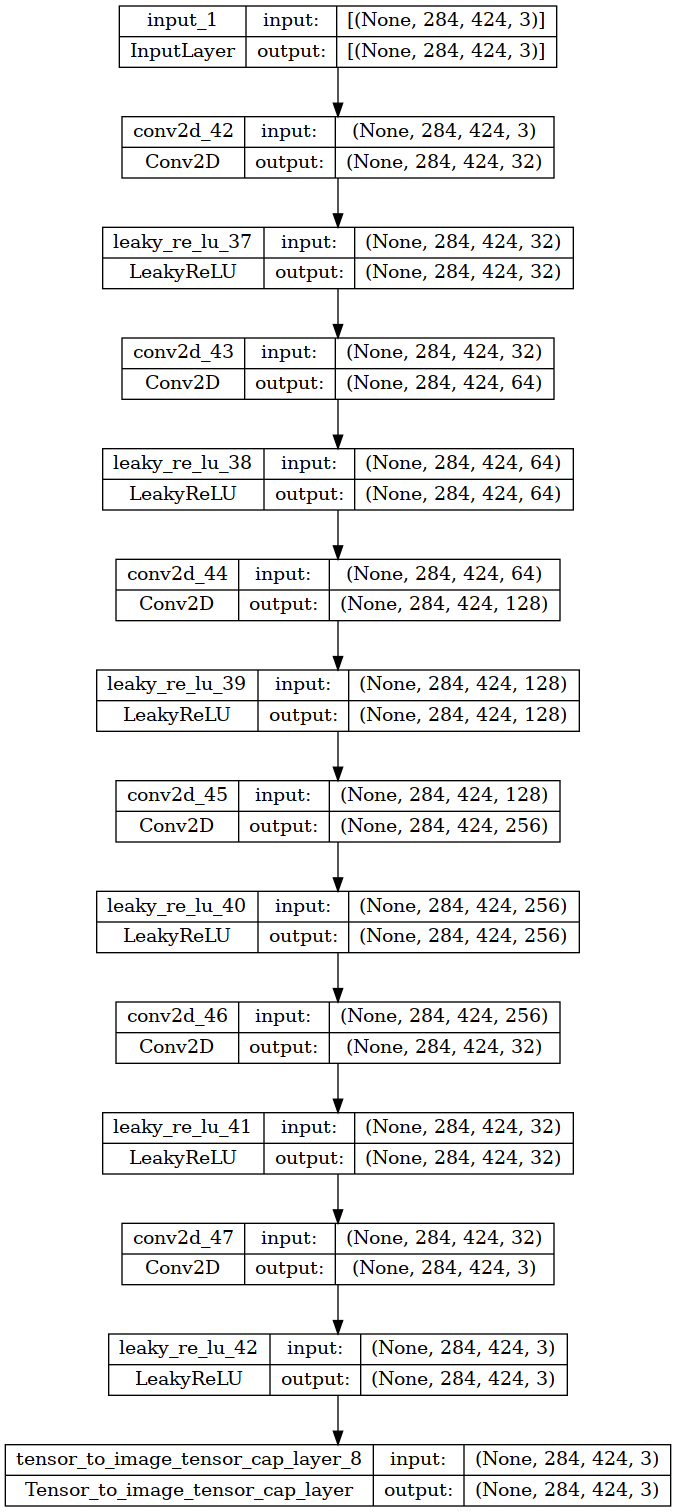

In [100]:
x = inputs

filters = [32, 64, 128, 256, 32, 3] # Numero di filtri per ciascun layer

for i in range(len(filters)):
    x = keras.layers.Conv2D(
        filters = filters[i],
        kernel_size = 3,
        padding = 'same',
        strides = 1
    )(x)
    x = activation_layer_lrelu()(x)

x = Tensor_to_image_tensor_cap_layer()(x)

outputs = x
net_convolutional = keras.Model(inputs, outputs)
keras.utils.plot_model(net_convolutional, show_shapes=True)

In [101]:
net_convolutional.compile(
    loss = loss_mae,
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics = metrics,
)

In [102]:
checkpoint_callback_convolutional, checkpoint_manager_convolutional = initialize_checkpoint_manager(
    net_convolutional,
    "net_convolutional",
    restore = False,
)

checkpoints will be saved to /mnt/e/Data/Deep Learning/See in the dark/checkpoint/net_convolutional


In [103]:
history = net_convolutional.fit(
    dataset_training_augmented_batched,
    validation_data = dataset_validation_augmented_batched,
    epochs = num_epoch,
    #initial_epoch = 9,
    callbacks = [checkpoint_callback_convolutional, early_stopping_callback],
    verbose = 2,
)

Epoch 1/20


2023-06-22 01:10:44.135425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 01:10:44.135708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 01:35:11.591417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-22 01:35:11.59

187/187 - 1664s - loss: 52.9993 - mean_absolute_error: 53.0201 - mean_squared_error: 5231.5752 - ssim_loss: 0.3970 - accuracy: 0.6552 - val_loss: 46.4560 - val_mean_absolute_error: 46.1380 - val_mean_squared_error: 3923.8372 - val_ssim_loss: 0.3557 - val_accuracy: 0.7534 - 1664s/epoch - 9s/step
Epoch 2/20
187/187 - 1657s - loss: 46.0765 - mean_absolute_error: 46.1088 - mean_squared_error: 3885.4446 - ssim_loss: 0.3608 - accuracy: 0.6960 - val_loss: 46.0018 - val_mean_absolute_error: 45.9602 - val_mean_squared_error: 3706.9968 - val_ssim_loss: 0.3616 - val_accuracy: 0.7534 - 1657s/epoch - 9s/step
Epoch 3/20
187/187 - 1646s - loss: 41.7710 - mean_absolute_error: 41.7709 - mean_squared_error: 3136.0007 - ssim_loss: 0.3470 - accuracy: 0.7401 - val_loss: 47.6918 - val_mean_absolute_error: 47.1326 - val_mean_squared_error: 3829.4814 - val_ssim_loss: 0.3424 - val_accuracy: 0.7535 - 1646s/epoch - 9s/step
Epoch 4/20
187/187 - 1648s - loss: 40.2226 - mean_absolute_error: 40.2291 - mean_squared_e

In [104]:
save_model(
    net_convolutional,
    type_name = "convolutional",
    parameters = "32-64-128-256-32-3",
    augmented = True,
    epochs = str(num_epoch),
    batch_size = str(batch_size),
    activation = "lrelu",
    loss = "mae",
    optimizer = "adam",
    early_stopping = "loss-5"
)

INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/convolutional_32-64-128-256-32-3_aug_lrelu_mae_adam_20_10_loss-5/tf_model/assets


INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/convolutional_32-64-128-256-32-3_aug_lrelu_mae_adam_20_10_loss-5/tf_model/assets


Model saved to /mnt/e/Data/Deep Learning/See in the dark/model/convolutional_32-64-128-256-32-3_aug_lrelu_mae_adam_20_10_loss-5/tf_model/
Checkpoint saved to /mnt/e/Data/Deep Learning/See in the dark/model/convolutional_32-64-128-256-32-3_aug_lrelu_mae_adam_20_10_loss-5/checkpoint/


'/mnt/e/Data/Deep Learning/See in the dark/model/convolutional_32-64-128-256-32-3_aug_lrelu_mae_adam_20_10_loss-5'

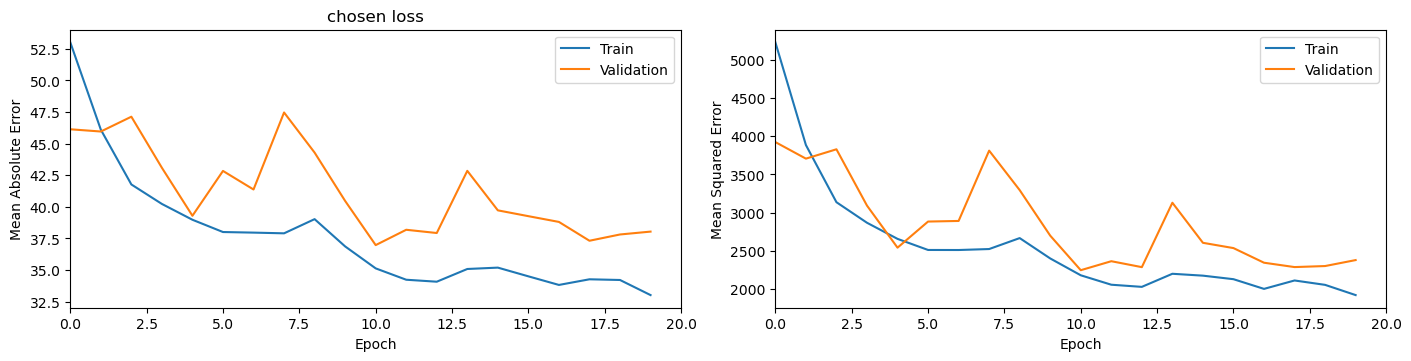

In [105]:
plot_metrics(history, chosen_loss_str = "mean_absolute_error", xlim = num_epoch)

2023-06-22 10:59:12.876692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 13 of 100
2023-06-22 10:59:21.643813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 25 of 100
2023-06-22 10:59:29.992235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 37 of 100
2023-06-22 10:59:37.988092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 49 of 100
2023-06-22 10:59:55.126384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 73 of 100
2023-06-22 11:00:03.285712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 100
2023-06-22 11:00:10.564161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

1/1 [==============================] - 0s 18ms/step


'/mnt/e/Data/Deep Learning/See in the dark/output/human check out.png'

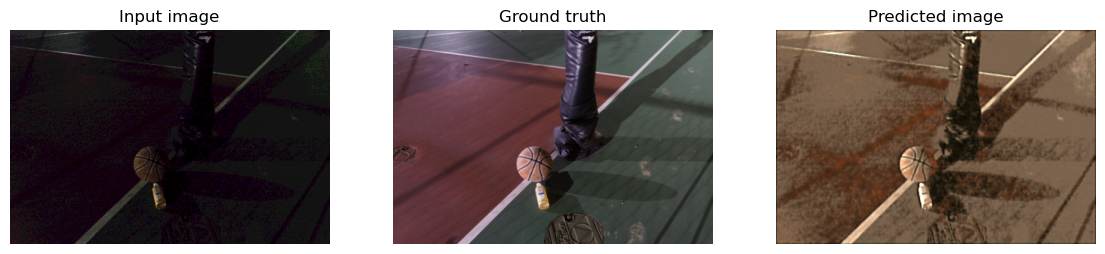

In [113]:
img_in, img_gt, img_out = human_check(net_convolutional, random = True)
save_image(img_out, name = "human check out")

In [114]:
score_net_convolutional = net_convolutional.evaluate(dataset_testing_batched, return_dict = True)
score_net_convolutional

2023-06-22 11:05:19.985447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 480s 8s/step - loss: 34.8675 - mean_absolute_error: 34.8824 - mean_squared_error: 2071.0591 - ssim_loss: 0.3119 - accuracy: 0.7253


{'loss': 34.86747360229492,
 'mean_absolute_error': 34.882442474365234,
 'mean_squared_error': 2071.05908203125,
 'ssim_loss': 0.3118799328804016,
 'accuracy': 0.7253372669219971}

### Dense CNN model

Dense networks after each block of layers concatenate the output of all the previous blocks. This allows the loss to propagate (almost) directly to every layer block.

We built a function that creates dense convolutional networks referring to our first try on convolutional networks. We reduced the size by one layer (no 256 filters layer) due to memory problems.

In [58]:
def generate_dense_cnn(filters = [16, 32, 64, 128, 3]):
    x = inputs

    outputs_of_layers_before = [x]

    for i in range(len(filters)):
        # fully connects with previous outputs
        x = keras.layers.Concatenate(axis = 3)(outputs_of_layers_before)
        # convolution
        x = keras.layers.Conv2D(
            filters = filters[i],
            kernel_size = 3,
            padding = 'same',
            strides = 1
        )(x)
        # activation
        x = activation_layer_lrelu()(x)
        # append to list of outputs
        outputs_of_layers_before.append(x)
    
    x = Tensor_to_image_tensor_cap_layer()(x)

    outputs = x
    return keras.Model(inputs, outputs)

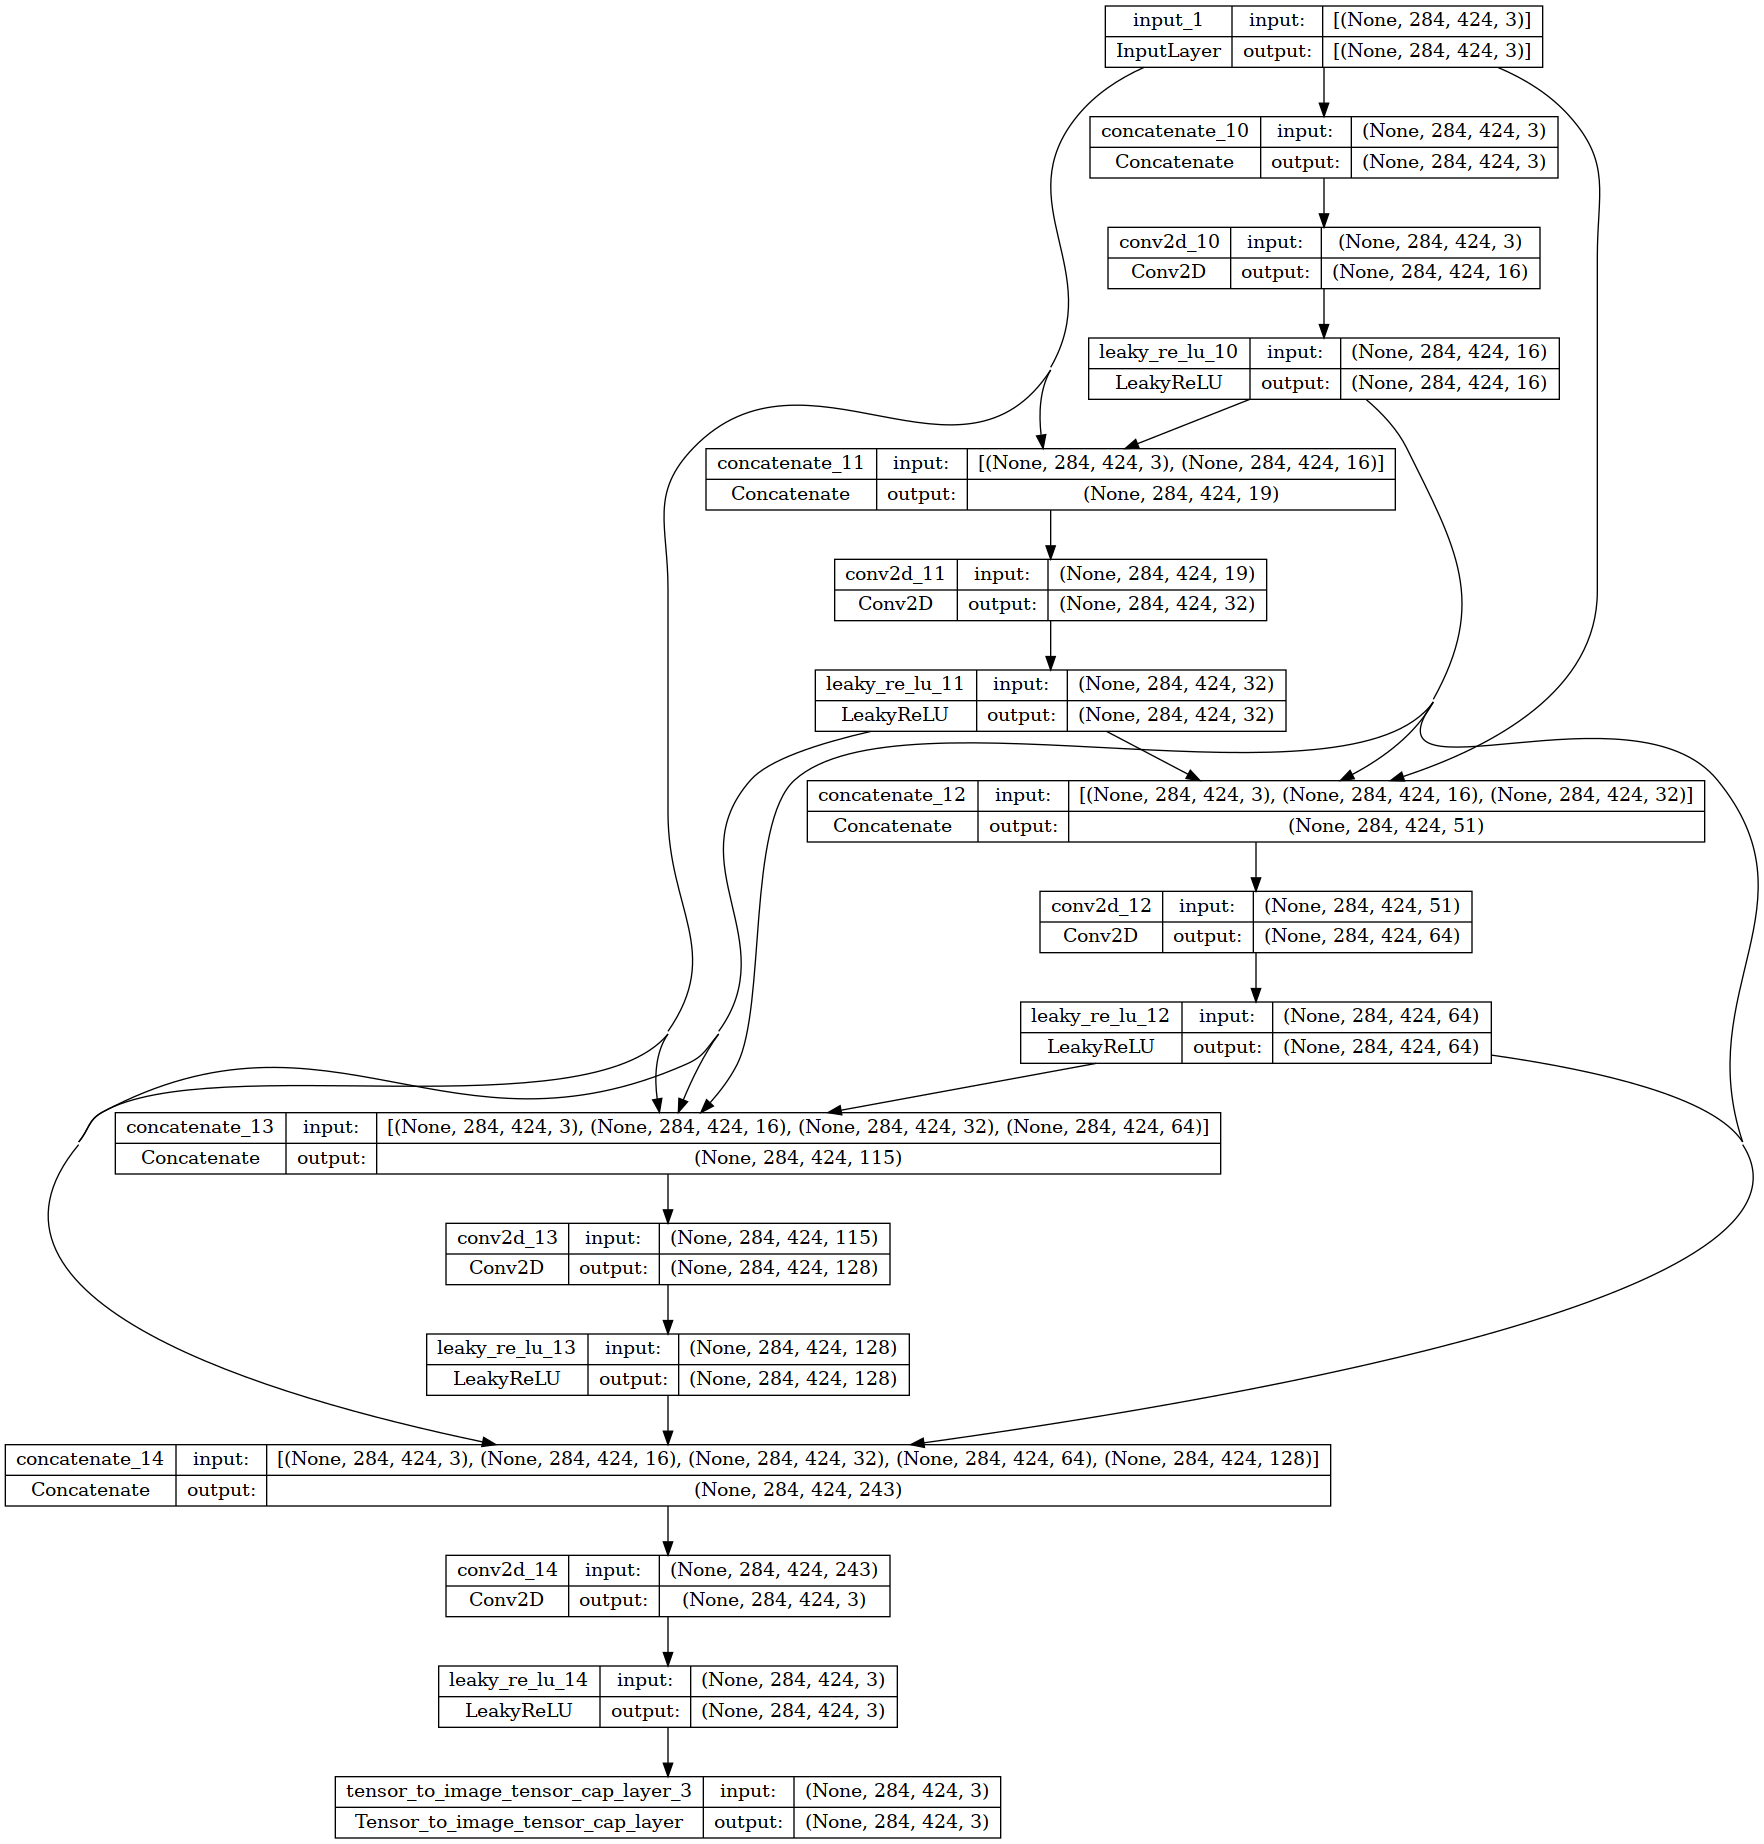

In [61]:
net_dense_cnn = generate_dense_cnn()
keras.utils.plot_model(net_dense_cnn, show_shapes=True)

In [62]:
net_dense_cnn.compile(
    loss = loss_mse,
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics = metrics,
)

In [63]:
checkpoint_callback_dense_cnn, checkpoint_manager_dense_cnn = initialize_checkpoint_manager(
    net_dense_cnn,
    "dense_cnn",
    restore = False,
)

checkpoints will be saved to /mnt/e/Data/Deep Learning/See in the dark/checkpoint/dense_cnn


In [64]:
history_net_dense_cnn = net_dense_cnn.fit(
    dataset_training_augmented_batched,
    validation_data = dataset_validation_augmented_batched,
    epochs = num_epoch,
    #initial_epoch = 10,
    callbacks = [checkpoint_callback_dense_cnn, print_epoch_callback, early_stopping_callback],
    verbose = 2,
)

Current epoch: 1
Epoch 1/20


2023-06-25 19:15:13.527679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-25 19:15:13.527887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-25 19:15:26.413416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-25 19:15:33.695279: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may m

187/187 - 1707s - loss: 3925.5474 - mean_absolute_error: 47.0827 - mean_squared_error: 3928.1873 - ssim_loss: 0.3555 - accuracy: 0.7271 - val_loss: 4071.8933 - val_mean_absolute_error: 49.6775 - val_mean_squared_error: 4134.0200 - val_ssim_loss: 0.3720 - val_accuracy: 0.7551 - 1707s/epoch - 9s/step
Current epoch: 2
Epoch 2/20
187/187 - 1655s - loss: 3160.2356 - mean_absolute_error: 42.1501 - mean_squared_error: 3159.5886 - ssim_loss: 0.3528 - accuracy: 0.7385 - val_loss: 3477.0535 - val_mean_absolute_error: 45.5645 - val_mean_squared_error: 3488.0295 - val_ssim_loss: 0.3587 - val_accuracy: 0.7551 - 1655s/epoch - 9s/step
Current epoch: 3
Epoch 3/20
187/187 - 1648s - loss: 2613.5850 - mean_absolute_error: 38.9109 - mean_squared_error: 2613.0247 - ssim_loss: 0.3526 - accuracy: 0.7415 - val_loss: 3117.8291 - val_mean_absolute_error: 43.6207 - val_mean_squared_error: 3117.7908 - val_ssim_loss: 0.3379 - val_accuracy: 0.7551 - 1648s/epoch - 9s/step
Current epoch: 4
Epoch 4/20
187/187 - 1659s 

In [65]:
save_model(
    net_dense_cnn,
    type_name = "dense_cnn",
    parameters = "16-32-64-128-3",
    augmented = True,
    epochs = str(num_epoch),
    batch_size = str(batch_size),
    activation = "lrelu",
    loss = "mse",
    optimizer = "adam",
    early_stopping = "loss-5"
)

INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/dense_cnn_16-32-64-128-3_aug_lrelu_mse_adam_20_10_loss-5/tf_model/assets


INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/dense_cnn_16-32-64-128-3_aug_lrelu_mse_adam_20_10_loss-5/tf_model/assets


Model saved to /mnt/e/Data/Deep Learning/See in the dark/model/dense_cnn_16-32-64-128-3_aug_lrelu_mse_adam_20_10_loss-5/tf_model/
Checkpoint saved to /mnt/e/Data/Deep Learning/See in the dark/model/dense_cnn_16-32-64-128-3_aug_lrelu_mse_adam_20_10_loss-5/checkpoint/


'/mnt/e/Data/Deep Learning/See in the dark/model/dense_cnn_16-32-64-128-3_aug_lrelu_mse_adam_20_10_loss-5'

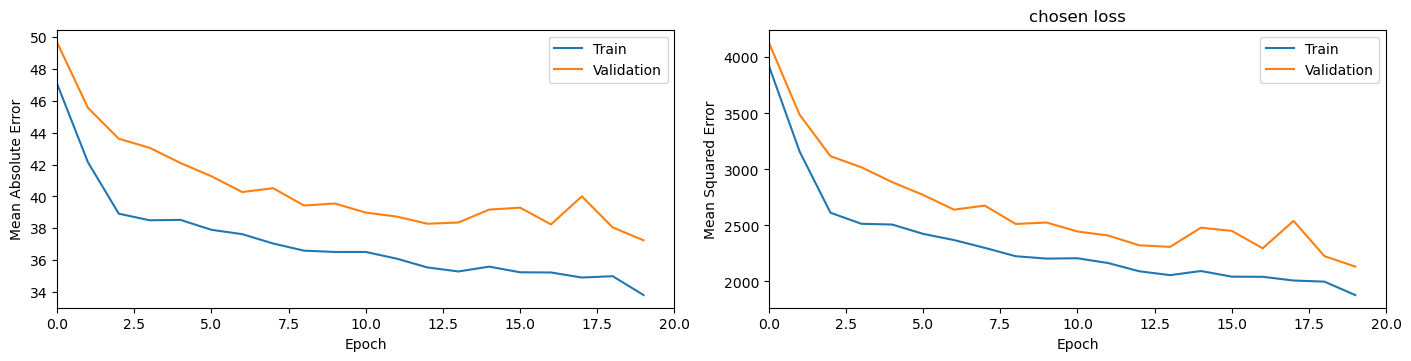

In [67]:
plot_metrics(history_net_dense_cnn, chosen_loss_str = "mean_squared_error", xlim = num_epoch)

2023-06-26 05:44:46.529048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 100
2023-06-26 05:44:53.407733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 21 of 100
2023-06-26 05:45:07.800460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 100
2023-06-26 05:45:14.380591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 100
2023-06-26 05:45:28.652246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 71 of 100
2023-06-26 05:45:35.476785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 81 of 100
2023-06-26 05:45:42.053692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1/1 [==============================] - 0s 17ms/step


'/mnt/e/Data/Deep Learning/See in the dark/output/human check out.png'

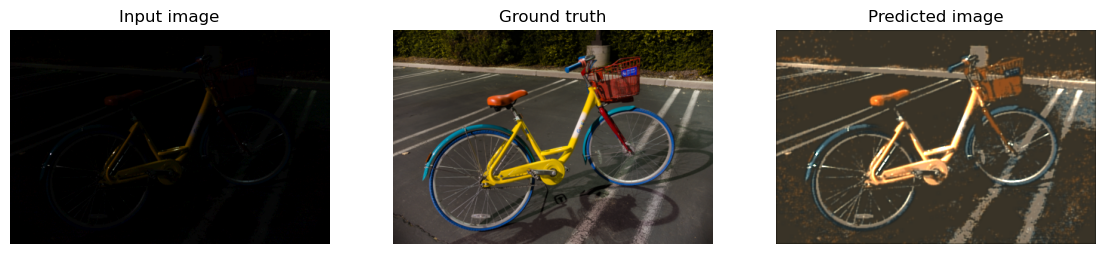

In [74]:
img_in, img_gt, img_out = human_check(net_dense_cnn, random = True)
save_image(img_out, name = "human check out")

In [75]:
score_net_dense_cnn = net_dense_cnn.evaluate(dataset_testing_batched, return_dict = True)
score_net_dense_cnn

2023-06-26 05:46:57.325869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 469s 8s/step - loss: 1919.8990 - mean_absolute_error: 34.3372 - mean_squared_error: 1921.5269 - ssim_loss: 0.3295 - accuracy: 0.7355


{'loss': 1919.8990478515625,
 'mean_absolute_error': 34.337242126464844,
 'mean_squared_error': 1921.52685546875,
 'ssim_loss': 0.3294636011123657,
 'accuracy': 0.7354792356491089}

### U-Net model

The U-Net model was first introduced with the paper ["U-Net: Convolutional Networks for Biomedical Image Segmentation", Olaf Ronneberger, Philipp Fischer, Thomas Brox, May 2015](https://arxiv.org/abs/1505.04597), it had a great success also outside the intial field.

We adopted this model as the main model following our reference paper ["Learning to See in the Dark", Chen Chen, Qifeng Chen, Jia Xu, Vladlen Koltun, May 2018](https://arxiv.org/abs/1805.01934) the specifications for the training in the code related to the paper sets this parameters:

- L1 loss, another name for Mean Absolute Error
- Adam optimizer with learning rate $10^{-4}$ for half traing and $10^{-5}$ the remaining half
- 4000 epochs
- 4 encoder and 4 decoder blocks plus bridge (all filter dimension 3x3) and final convolution (filter 1x1). Filters number: 32, 64, 128, 256, 512, 256, 128, 64, 32, 12

In the U-Net structure we call

- Encoder block: convolution, convolution, max pooling (no max pooling for the skip connenction)
- Decoder block: deconvolution, concatenation with skip connection, convolution, convolution
- Bridge block: convolution, convolution

The paper states that they obtained better results with the original raw images respect to standard images in the (s)RGB space: "We have found that operating directly on raw sensor data is much more effective in extreme low-light conditions" (5.2 Controlled experiments, Input color space). Since we cannot hope to complete a training with such parameters, we focused instead on obtaining some minimum results on standard PNG images: we focused on the availability to users instead of results. Of course we use a much more limited number of epochs and we compensed it partially with a higher learning rate. With the same intentions we reduced the size of the orignal U-Net with only 3 encoders (or decoders) blocks and, starting from 16 filters, we tried to compensate the reduction with a multiplicatinve increase in the number of fliters of 4 (in place of 2)

In [59]:
print("Batch size:", batch_size)
print("Number of epochs:", num_epoch)
print("Learning rate:", learning_rate)

Batch size: 10
Number of epochs: 20
Learning rate: 0.001


In [60]:
# group the unet functions under the same class
class UNet:

    @staticmethod
    def conv_layer(filters, kernel_size, normalize = False):
        def layer(inputs):
            # Convolution
            x = keras.layers.Conv2D(
                filters = filters,
                kernel_size = kernel_size,
                padding = 'same',
            )(inputs)
            # Batch normalization
            if (normalize):
                x = tf.keras.layers.BatchNormalization()(x)
            # Activation
            x = activation_layer_lrelu()(x)
            return x
        return layer

    @staticmethod
    def double_conv_layer(filters, kernel_size):
        def layer(inputs):
            # Convolution 1
            x = UNet.conv_layer(filters, kernel_size)(inputs)
            # Convolution 2
            x = UNet.conv_layer(filters, kernel_size)(x)
            return x
        return layer

    @staticmethod
    def encoder_block_layer(filters, kernel_size=3):
        def layer(inputs):
            # Convolution 1 and 2
            x = UNet.double_conv_layer(filters, kernel_size)(inputs)
            skip_connection = x
            # Max pooling
            x = tf.keras.layers.MaxPooling2D(pool_size = 2)(x)
            return x, skip_connection
        return layer

    @staticmethod
    def bridge_block_layer(filters, kernel_size=3):
        def layer(inputs):
            # Convolution 1 and 2
            x = UNet.double_conv_layer(filters, kernel_size)(inputs)
            return x
        return layer

    @staticmethod
    def decoder_block_layer(filters, kernel_size=3) -> tf.Tensor:
        def layer(inputs, skip_connection):
            # Deconvolution
            x = keras.layers.Conv2DTranspose(
                filters = filters,
                kernel_size = kernel_size,
                strides = 2, # was 2
                padding = "same",
            )(inputs)
            # The Conv2DTranspose does not always match the size of skip_connection
            # since the output dimensions x and y (index 1 and 2) can be even only,
            # while the skip_connenction tensor may have odd dimensions.
            x = tf.image.resize(
                x,
                tf.shape(skip_connection)[1:3]
            )
            # concatenation
            x = keras.layers.Concatenate(axis = 3)([x, skip_connection])
            # Convolution 1 and 2
            x = UNet.double_conv_layer(filters, kernel_size)(x)
            return x
        return layer

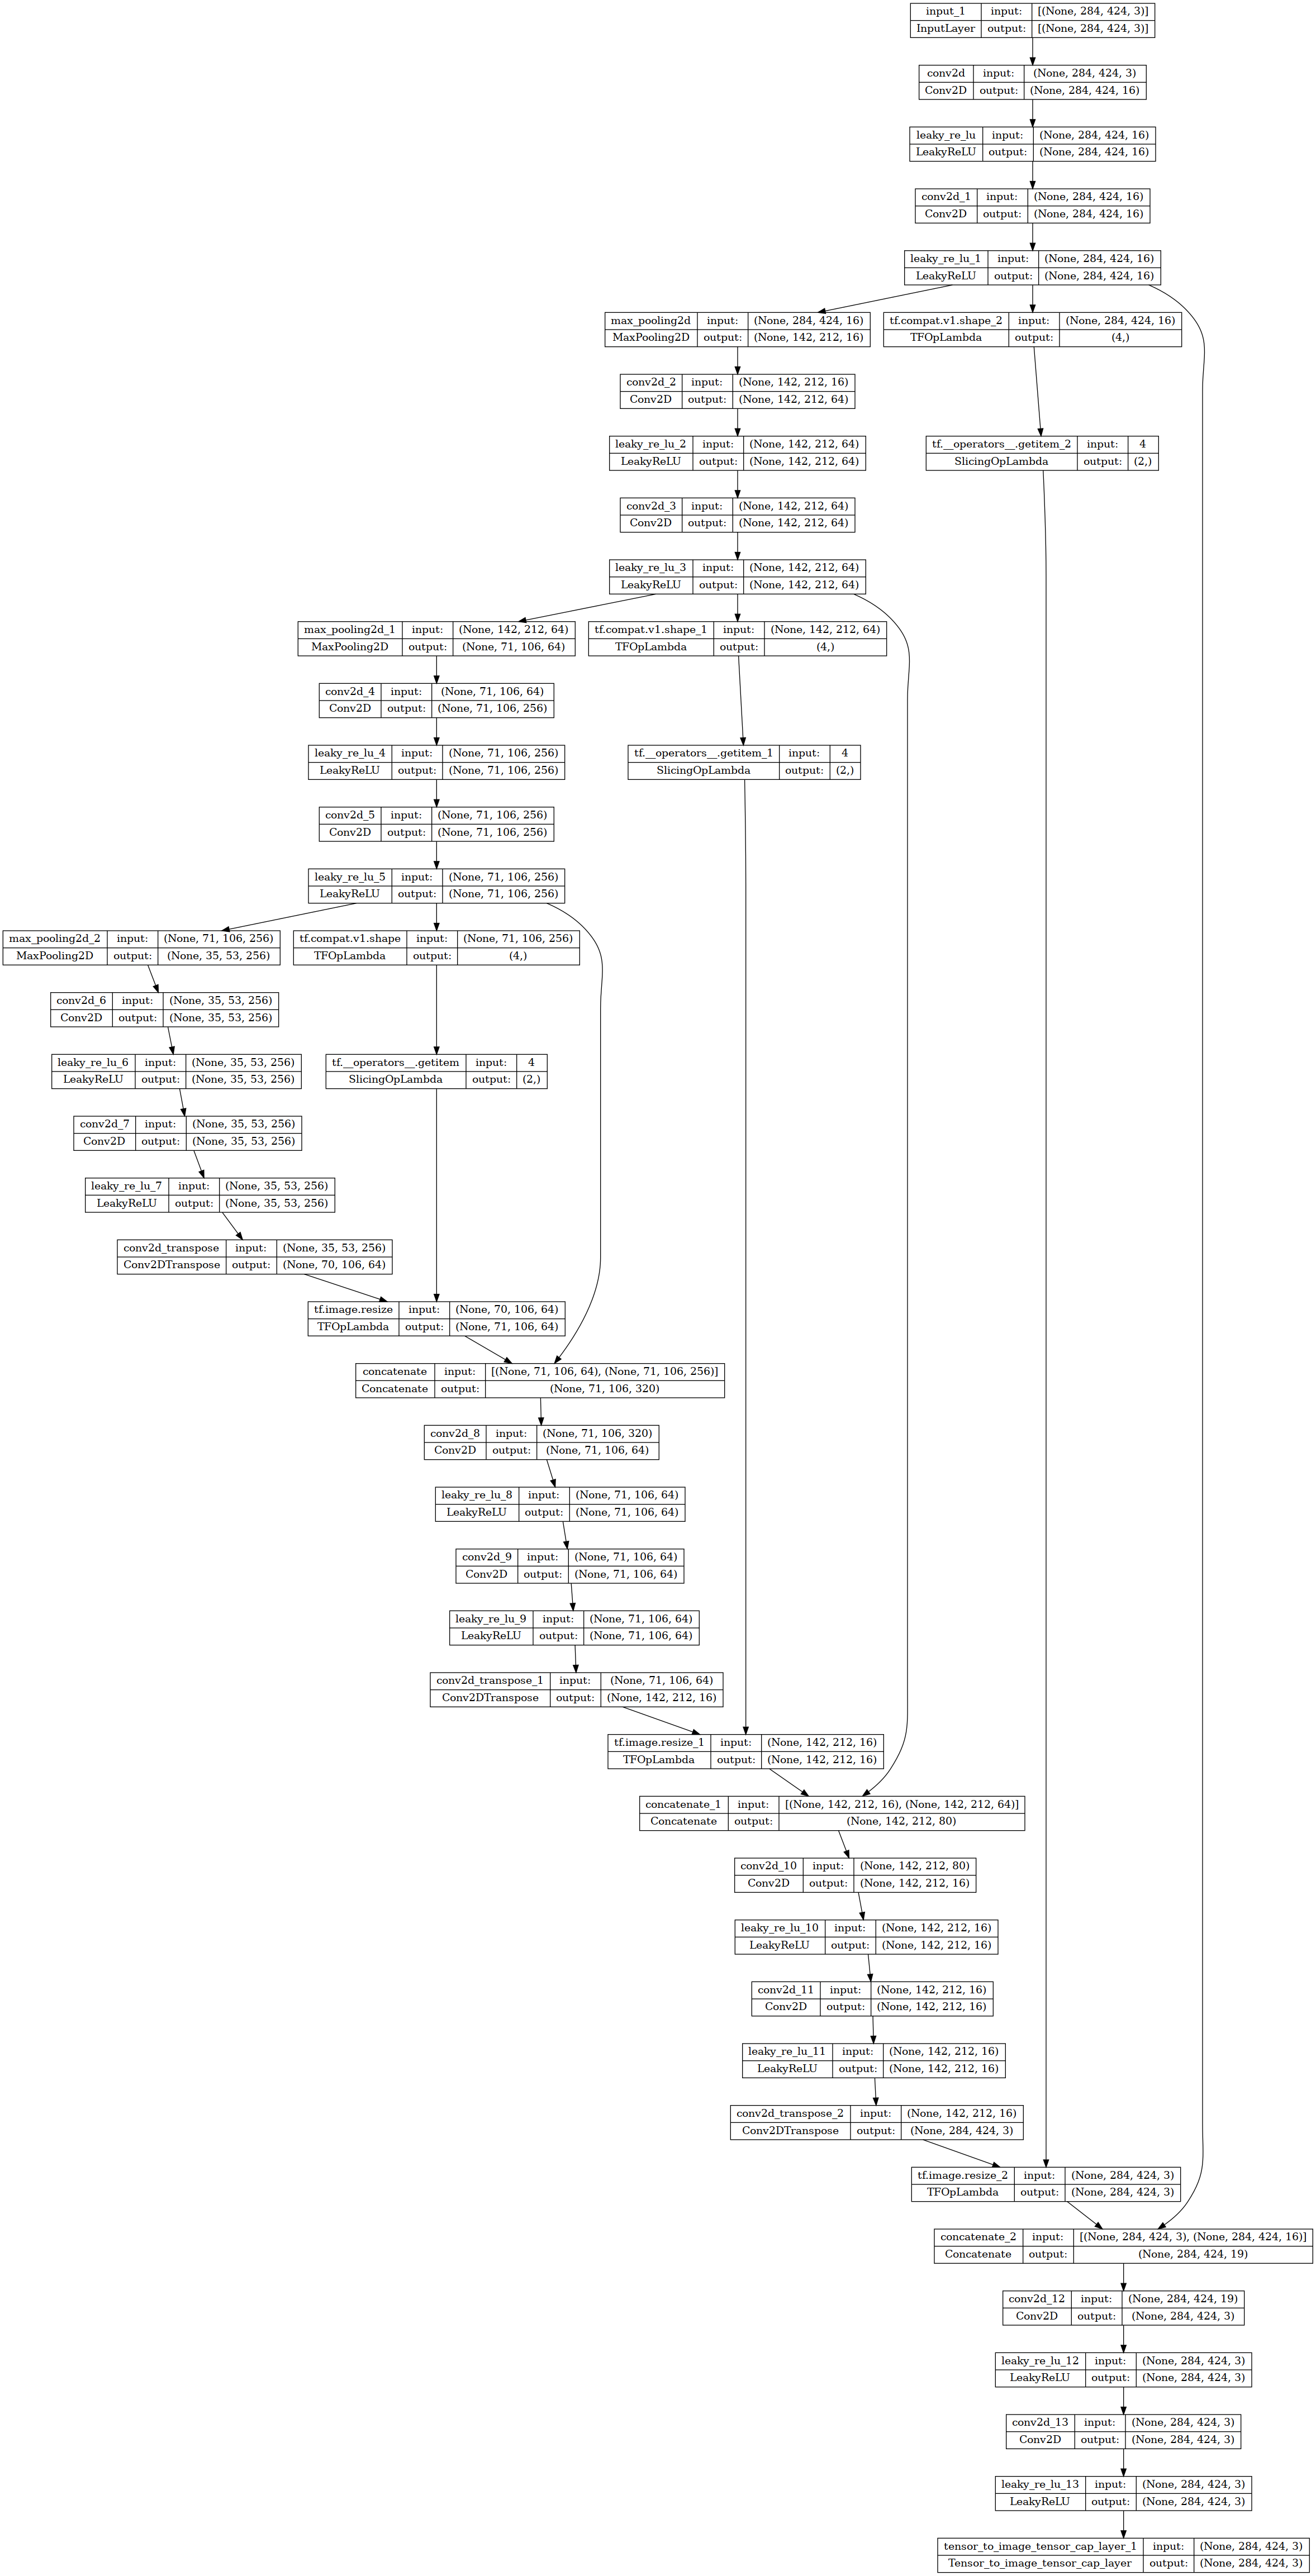

In [61]:
x = inputs
x, skip1 = UNet.encoder_block_layer(filters = 4*4)          (x)
x, skip2 = UNet.encoder_block_layer(filters = 4*4*4)        (x)
x, skip3 = UNet.encoder_block_layer(filters = 4*4*4*4)      (x)
x =        UNet.bridge_block_layer (filters = 4*4*4*4)      (x)
x =        UNet.decoder_block_layer(filters = 4*4*4)        (x, skip3)
x =        UNet.decoder_block_layer(filters = 4*4)          (x, skip2)
x =        UNet.decoder_block_layer(filters = img_channels) (x, skip1)
x = Tensor_to_image_tensor_cap_layer()(x)
outputs = x
net_u = keras.Model(inputs, outputs)
keras.utils.plot_model(net_u, show_shapes=True)

In [58]:
#net_u = keras.models.load_model(path.normpath(path.join(base_dir, "./model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/tf_model/")))

TypeError: Error when deserializing class 'MeanAbsoluteError' using config={'reduction': 'auto', 'name': 'mean_absolute_error'}.

Exception encountered: __init__() got an unexpected keyword argument 'reduction'

In [62]:
net_u.load_weights(path.normpath(path.join(base_dir, "./model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/checkpoint/")) + "/")

In [68]:
net_u.compile(
    loss = loss_mse,
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
    metrics = metrics,
)

In [66]:
checkpoint_callback_u, checkpoint_manager_u = initialize_checkpoint_manager(
    net_u,
    "net_u",
    restore = False,
)

checkpoints will be saved to /mnt/e/Data/Deep Learning/See in the dark/checkpoint/net_u


In [83]:
history_net_u = net_u.fit(
    dataset_training_batched,
    validation_data = dataset_validation_batched,
    epochs = num_epoch,
    #initial_epoch = 10,
    callbacks = [checkpoint_callback_u, print_epoch_callback, early_stopping_callback],
    verbose = 2,
)

Current epoch: 1
Epoch 1/20


2023-06-26 16:02:56.551162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-26 16:27:20.349782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


187/187 - 1658s - loss: 5987.0513 - mean_absolute_error: 58.3694 - mean_squared_error: 6003.9336 - ssim_loss: 0.5371 - accuracy: 0.7073 - val_loss: 9178.5654 - val_mean_absolute_error: 77.1537 - val_mean_squared_error: 9345.8105 - val_ssim_loss: 0.6019 - val_accuracy: 0.6126 - 1658s/epoch - 9s/step
Current epoch: 2
Epoch 2/20
187/187 - 1653s - loss: 4241.0083 - mean_absolute_error: 48.6407 - mean_squared_error: 4242.4189 - ssim_loss: 0.4652 - accuracy: 0.7249 - val_loss: 3617.0515 - val_mean_absolute_error: 46.5865 - val_mean_squared_error: 3612.5898 - val_ssim_loss: 0.3704 - val_accuracy: 0.7348 - 1653s/epoch - 9s/step
Current epoch: 3
Epoch 3/20
187/187 - 1653s - loss: 3127.2871 - mean_absolute_error: 41.5684 - mean_squared_error: 3128.8831 - ssim_loss: 0.3832 - accuracy: 0.7395 - val_loss: 2958.7432 - val_mean_absolute_error: 42.2303 - val_mean_squared_error: 2953.4238 - val_ssim_loss: 0.3549 - val_accuracy: 0.7422 - 1653s/epoch - 9s/step
Current epoch: 4
Epoch 4/20
187/187 - 1708s 

In [84]:
save_model(
    net_u,
    type_name = "unet",
    parameters = "16_x4_3", # start with 16 filters, multiply filter x 4 at each layer, 3 layers bridge excluded and 16 filters included, no normalization
    augmented = False,
    epochs = str(num_epoch),
    batch_size = str(batch_size),
    activation = "lrelu",
    loss = "mse",
    optimizer = "adam",
    early_stopping = "loss-5"
)

2023-06-27 00:49:46.078433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-06-27 00:49:46.114780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,64]
	 [[{{node inputs}}]]
2023-06-27 00:49:46.149788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-0

INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/tf_model/assets


INFO:tensorflow:Assets written to: /mnt/e/Data/Deep Learning/See in the dark/model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/tf_model/assets


Model saved to /mnt/e/Data/Deep Learning/See in the dark/model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/tf_model/
Checkpoint saved to /mnt/e/Data/Deep Learning/See in the dark/model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5/checkpoint/


'/mnt/e/Data/Deep Learning/See in the dark/model/unet_16_x4_3_n-aug_lrelu_mse_adam_20_10_loss-5'

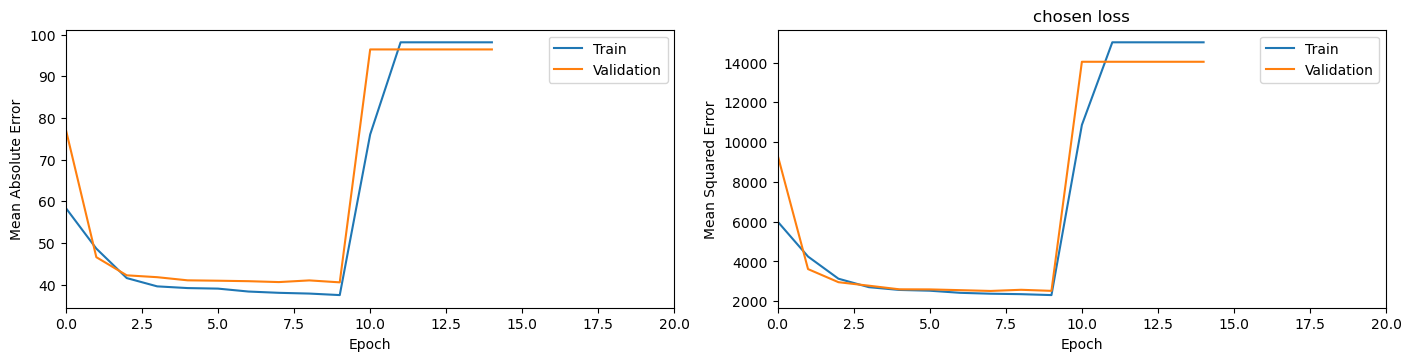

In [85]:
plot_metrics(history_net_u, chosen_loss_str = "mean_squared_error", xlim = num_epoch)

2023-06-27 07:55:06.442216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 100
2023-06-27 07:55:13.451243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 21 of 100
2023-06-27 07:55:29.674839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 41 of 100
2023-06-27 07:55:37.361778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 100
2023-06-27 07:55:45.159666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 61 of 100
2023-06-27 07:55:59.206247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 81 of 100
2023-06-27 07:56:05.911712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this 

1/1 [==============================] - 0s 20ms/step


'/mnt/e/Data/Deep Learning/See in the dark/output/human check out.png'

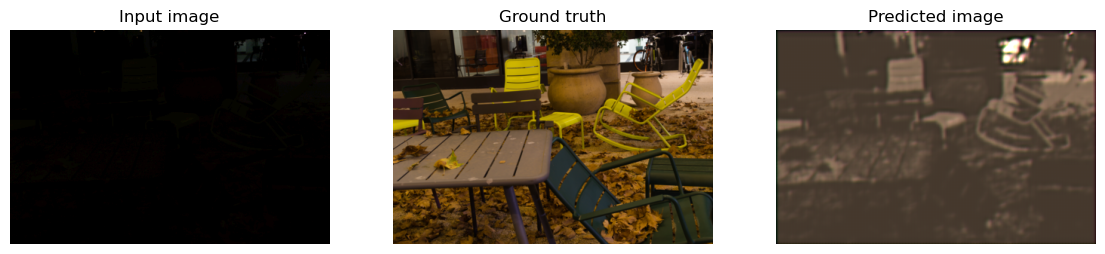

In [73]:
img_in, img_gt, img_out = human_check(net_u, random = True)
save_image(img_out, name = "human check out")

In [69]:
score_net_u = net_u.evaluate(dataset_testing_batched, return_dict = True)
score_net_u

2023-06-27 07:20:45.664131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 479s 8s/step - loss: 2177.4780 - mean_absolute_error: 36.9108 - mean_squared_error: 2179.0500 - ssim_loss: 0.3523 - accuracy: 0.7148


{'loss': 2177.47802734375,
 'mean_absolute_error': 36.9107780456543,
 'mean_squared_error': 2179.050048828125,
 'ssim_loss': 0.3523009717464447,
 'accuracy': 0.7147752046585083}